In [91]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [92]:
import numpy as np
import time
import matplotlib.pyplot
%matplotlib inline

In [93]:
def convert(imgf, labels, outfile, n):
    imgf = open(imgf, "rb")
    csvf = open(outfile, "w")
    labelf = open(labels, "rb")

    imgf.read(16)
    labelf.read(8)
    images = []

    for i in range(n):
        image = [ord(labelf.read(1))]
        for j in range(28*28):
            image.append(ord(imgf.read(1)))
        images.append(image)

    for image in images:
        csvf.write(",".join(str(pix) for pix in image)+"\n")
    imgf.close()
    labelf.close()
    csvf.close()


In [94]:
mnist_train_x = "train-images.idx3-ubyte"
mnist_train_y = "train-labels.idx1-ubyte"
mnist_test_x = "t10k-images.idx3-ubyte"
mnist_test_y = "t10k-labels.idx1-ubyte"

In [95]:
convert(mnist_train_x, mnist_train_y, "mnist_train.csv", 60000)
convert(mnist_test_x, mnist_test_y, "mnist_test.csv", 10000)

In [96]:
train_file = open("mnist_train.csv", 'r')
train_list = train_file.readlines()
train_file.close()

In [97]:
len(train_list)

60000

In [98]:
#train_list[15]

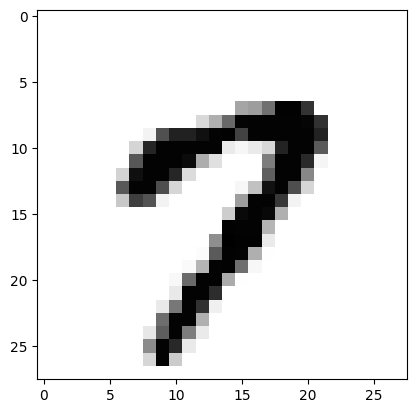

In [99]:
# reshape ve 28x28 va plot thanh 1 anh
all_values = train_list[15].split(',')
image_array = np.asfarray(all_values[1:]).reshape((28,28))
matplotlib.pyplot.imshow(image_array, cmap='Greys', interpolation='None')

In [100]:

# scale input to range 0.01 to 1.00
#scaled_input_train = (np.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
# print(scaled_input_train)

In [101]:
test_file = open("mnist_test.csv", 'r')
test_list = test_file.readlines()
test_file.close()

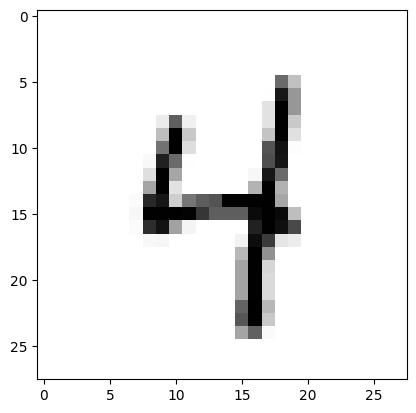

In [102]:
all_values = test_list[19].split(',')
image_array = np.asfarray(all_values[1:]).reshape((28,28))
matplotlib.pyplot.imshow(image_array, cmap='Greys', interpolation='None')

In [103]:
class my_NeuralNetwork:
  def __init__(self, sizes, epochs, lr):
    self.sizes = sizes
    self.epochs = epochs
    self.lr = lr

    # number of nodes in each layer
    input_layer=self.sizes[0]
    hidden_1=self.sizes[1]
    hidden_2=self.sizes[2]
    hidden_3=self.sizes[3]
    output_layer=self.sizes[4]

    self.params =   {
    'W1': np.random.randn(hidden_1, input_layer) * np.sqrt(2. / input_layer),
    'W2': np.random.randn(hidden_2, hidden_1) * np.sqrt(2. / hidden_1),
    'W3': np.random.randn(hidden_3, hidden_2) * np.sqrt(2. / hidden_2),
    'W4':np.random.randn(output_layer,hidden_3) * np.sqrt(1. / hidden_3)
      }

  # ReLu activation
  def relu(self, x, derivative=False):
       if derivative:
          return np.where(x > 0, 1, 0)
       return np.maximum(0, x)

  # Softmax activation
  def softmax(self, x, derivative=False):
      # Numerically stable with large exponentials
      exps = np.exp(x - x.max())
      if derivative:
          return exps / np.sum(exps, axis=0) * (1 - exps / np.sum(exps, axis=0))
      return exps / np.sum(exps, axis=0)

      # Forward propagation
  def forward_pass(self, x_train):
      params = self.params

      # input layer activations becomes sample
      params['A0'] = x_train

      # input layer to hidden layer 1
      params['Z1'] = np.dot(params["W1"], params['A0'])
      params['A1'] = self.relu(params['Z1'])

      # hidden layer 1 to hidden layer 2
      params['Z2'] = np.dot(params["W2"], params['A1'])
      params['A2'] = self.relu(params['Z2'])

      # hidden layer 2 to hidden 3
      params['Z3'] = np.dot(params["W3"], params['A2'])
      params['A3'] = self.relu(params['Z3'])

      # hidden 3 to output layer
      params['Z4'] = np.dot(params["W4"], params['A3'])
      params['A4'] = self.softmax(params['Z4'])

      # Output result
      return params['A4']

      # Back propagation
  def backward_pass(self, y_train, output):

      params = self.params
      change_w = {}

      # W4 update
      error = 2 * (output - y_train) / output.shape[0] * self.softmax(params['Z4'], derivative=True)
      change_w['W4'] = np.outer(error, params['A3'])

      # Calculate W3 update
      error = np.dot(params['W4'].T, error) * self.relu(params['Z3'], derivative=True)
      change_w['W3'] = np.outer(error, params['A2'])

      # Calculate W2 update
      error = np.dot(params['W3'].T, error) * self.relu(params['Z2'], derivative=True)
      change_w['W2'] = np.outer(error, params['A1'])

      # Calculate W1 update
      error = np.dot(params['W2'].T, error) * self.relu(params['Z1'], derivative=True)
      change_w['W1'] = np.outer(error, params['A0'])

      return change_w

  def update_network_parameters(self, changes_to_w):

          #Update network parameters according to update rule from
          # Stochastic Gradient Descent.
      for key, value in changes_to_w.items():
          self.params[key] -= self.lr * value

  def compute_accuracy(self, data_list, output_nodes):
      '''
          This function does a forward pass of x, then checks if the indices
          of the maximum value in the output equals the indices in the label
          y. Then it sums over each prediction and calculates the accuracy.
      '''
      predictions = []

      for x in data_list:
            all_values = x.split(',')
            inputs = (np.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
            targets = np.zeros(output_nodes) + 0.01
            targets[int(all_values[0])] = 0.99

            output = self.forward_pass(inputs)
            pred = np.argmax(output)
            predictions.append(pred == np.argmax(targets))
      return np.mean(predictions)

  def train(self, train_list, validation_list, output_nodes):
        start_time = time.time()
        batch_size = 32
        # Split train_list into training and validation sets
        split_ratio = 0.1
        split_index = int(len(train_list) * split_ratio)
        training_data = train_list[:split_index]
        validation_data = train_list[split_index:]
        for epoch in range(self.epochs):
            batch_start = 0
            np.random.shuffle(train_list)
            while batch_start < len(train_list):
                  batch_end = batch_start + batch_size
                  batch = train_list[batch_start:batch_end]

                  for record in batch:
                      all_values = record.split(',')
                      inputs = (np.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
                      targets = np.zeros(output_nodes) + 0.01
                      targets[int(all_values[0])] = 0.99

                      output = self.forward_pass(inputs)
                      changes_to_w = self.backward_pass(targets, output)
                      self.update_network_parameters(changes_to_w)

                  batch_start = batch_end

            train_accuracy = self.compute_accuracy(training_data, output_nodes)
            validation_accuracy = self.compute_accuracy(validation_data, output_nodes)
            test_accuracy = self.compute_accuracy(test_list, output_nodes)

            print(f"Epoch: {epoch+1}, Time Spent: {time.time() - start_time:.2f}s,  Train Accuracy: {train_accuracy * 100:.2f}%, Validation Accuracy: {validation_accuracy* 100:.2f}%")
            print('Test Accuracy: {0:.2f}%'.format(test_accuracy * 100))  # Evaluate on test set after training



In [ ]:
# Initialize and train the model
mNN = my_NeuralNetwork(sizes=[784, 256, 256, 256, 10], epochs=10, lr=0.001)
mNN.train(train_list, validation_list=None, output_nodes=10)

Epoch: 1, Time Spent: 169.32s,  Train Accuracy: 70.40%, Validation Accuracy: 69.34%
Test Accuracy: 70.43%
Epoch: 2, Time Spent: 337.65s,  Train Accuracy: 80.25%, Validation Accuracy: 78.95%
Test Accuracy: 79.60%
